# Fire and Smoke Detection using DCNN 

>Using Transfer Learning and GPU

### Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Libraries

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
4

%load_ext tensorboard
import tensorboard

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.applications import InceptionV3

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
path = "/content/drive/My Drive/DataSets/fire_dataset"

### Data Augmentation

In [4]:
datagen=ImageDataGenerator(
    validation_split=0.15,
    zoom_range=1,
	  width_shift_range=0.1,
	  height_shift_range=0.1,
    shear_range=0.1,
	  horizontal_flip=True,
	  fill_mode="nearest",
    rescale=1./255)

In [5]:
train_generator=datagen.flow_from_directory(path,
                                                 target_size=(224,224),
                                                 batch_size=32,
                                                 class_mode='binary',
                                                 shuffle=True,
                                                 subset='training')# set as training data


validation_generator = datagen.flow_from_directory(
                                                path, 
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='binary',
                                                shuffle=True,
                                                subset='validation') # set as validation data

Found 1070 images belonging to 2 classes.
Found 188 images belonging to 2 classes.


### Visualizing Training Data Post Augmentation

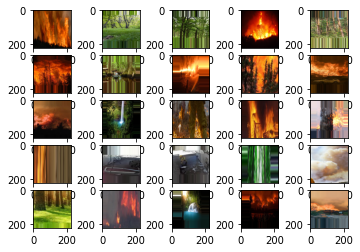

(224, 224, 3)


In [6]:
x,y = train_generator.next()

for i in range (25):
  plt.subplot(5,5,1 + i)
  igx1 = x[i]
  plt.imshow(igx1)
plt.show()
print(igx1.shape)

### Preparing Model

In [23]:
# model_new = InceptionV3(include_top =True, weights = None, classes=2, input_shape = (224,224,3))
# # for ix in range(776):
# #     model.layers[ix].trainable = False

# # x=model.output
# # # Add some new Fully connected layers
# # x=GlobalAveragePooling2D()(x)
# # x=Dense(256,activation='relu')(x)
# # x = Dropout(0.25)(x)
# # x=Dense(64,activation='relu')(x) 
# # preds=Dense(2, activation='softmax')(x) #final layer with softmax activation #5749 classes

# # model_new=Model(inputs=model.input,outputs=preds)


# # model_new=Model(inputs=model.input,outputs=preds)

In [11]:
model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(224,224,3)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# model.add(Conv2D(256,(3,3),activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid')) # whatever is the label, is returned


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 54, 54, 64)        0

In [13]:
model.compile(loss = "binary_crossentropy", optimizer ="adam", metrics = ["accuracy"] )

### Preparing Tensorboard

In [14]:
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard


log_dir = "/content/drive/My Drive/DataSets/fire/model/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

### Training Model

In [15]:
from numpy.random import seed
seed(1)


In [16]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

history=model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    callbacks = [tensorboard_callback],
                    epochs=50)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
 1/33 [..............................] - ETA: 0s - loss: 0.6876 - accuracy: 0.5000WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
33/33 [==============================] - 41s 1s/step - loss: 0.4850 - accuracy: 0.7630 - val_loss: 0.3198 - val_accuracy: 0.9062
Epoch 2/50
33/33 [==============================] - 41s 1s/step - loss: 0.2662 - accuracy: 0.9133 - val_loss: 0.3988 - val_accuracy: 0.7125
Epoch 3/50
33/33 [==============================] - 42s 1s/step - loss: 0.2418 - accuracy: 0.9152 - val_loss: 0.2264 - val_accuracy: 0.9312
Epoch 4/50
33/33 [==============================] - 42s 1s/step - loss: 0.2399 - accuracy: 0.9181 - val_loss: 0.2338 - val_accuracy: 0.9000
Epoc

### Visualizing Performance
>Saving Model .h5 and its History

In [19]:
from tensorflow.keras.models import load_model
model.save('/content/drive/My Drive/DataSets/model.h5')

In [20]:
import _pickle as p
with open("/content/drive/My Drive/DataSets/fire__detection.txt",'w') as f:
    for k in history.history.keys():
        print(k,file=f)
        for i in history.history[k]:
            print(i,file=f)

In [21]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


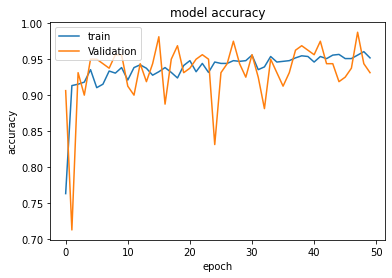

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

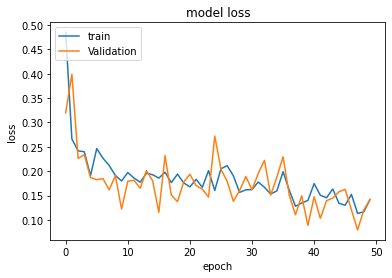

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()